In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


In [3]:
max_degree=20#定义多项式最大阶数
n_train,n_test=100,100
true_w=np.zeros(max_degree)#每一阶的权重
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 将前4个元素设置为非零值，这样可以确保多项式有一些具体的特征。
features=np.random.normal(size=(n_train+n_test,1))#生成正态分布的
np.random.shuffle(features)#打乱特征
# 对每项特征做幂运算 生成多项式特征（features，max_degree），其中偏置相当于多项式的常数项，即在幂次为0时的系数
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)#对每个特征进行gamma归一化，gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)#生成多项式标签
labels+=np.random.normal(scale=0.1,size=labels.shape)#添加随机噪声，增加模型的泛化性

In [9]:
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32)for x in[true_w,features,poly_features,labels]]

features[:2], poly_features[:2, :], labels[:2]


/var/folders/5c/x9z2lt995_s5w_g7t6z2m_sw0000gn/T/ipykernel_33238/1097537315.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32)for x in[true_w,features,poly_features,labels]]


(tensor([[ 0.0874],
         [-0.6378]]),
 tensor([[ 1.0000e+00,  8.7443e-02,  3.8232e-03,  1.1144e-04,  2.4361e-06,
           4.2605e-08,  6.2092e-10,  7.7564e-12,  8.4781e-14,  8.2373e-16,
           7.2030e-18,  5.7259e-20,  4.1725e-22,  2.8066e-24,  1.7530e-26,
           1.0219e-28,  5.5850e-31,  2.8728e-33,  1.3956e-35,  6.4228e-38],
         [ 1.0000e+00, -6.3784e-01,  2.0342e-01, -4.3249e-02,  6.8965e-03,
          -8.7978e-04,  9.3526e-05, -8.5221e-06,  6.7946e-07, -4.8154e-08,
           3.0715e-09, -1.7810e-10,  9.4665e-12, -4.6447e-13,  2.1161e-14,
          -8.9983e-16,  3.5872e-17, -1.3459e-18,  4.7693e-20, -1.6011e-21]]),
 tensor([5.0173, 3.2731]))

In [6]:
# 评估给定数据集上模型的损失
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)
    for x,y in data_iter:
        out=net(x)
        l=loss(out,y.reshape(out.shape))
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [14]:
#定义训练函数
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss=nn.MSELoss(reduction='none')#reduction 指定了损失值如何被规约（reduced）成一个标量。当 reduction='none' 时，nn.MSELoss 返回每个样本的损失值，不做任何规约。
    input_shape=train_features.shape[-1]
    #不设置偏置，因为我们在多项式中已经实现了它
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))
    # 为了确保计算负担不会过重，同时也考虑到样本数量可能很少，防止因为batch_size太大而导致内存溢出等问题。如果样本数量大于10，就使用10作为batch_size。
    batch_size=min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size=batch_size)
    test_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size=batch_size)
    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or(epoch+1)%20==0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:',net[0].weight.data.numpy())


weight: [[ 4.9686394  1.2681464 -3.3561478  5.406284 ]]


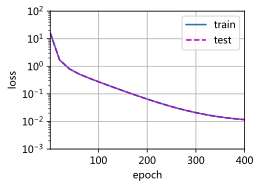

In [11]:
# 三阶多项式函数拟合(正常)
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

weight: [[3.6827781 2.9044802]]


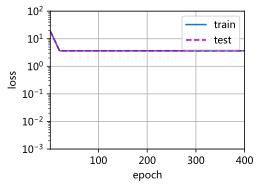

In [12]:
# 线性函数拟合
#线性函数拟合，减少该模型的训练损失相对困难。 在最后一个迭代周期完成后，训练损失仍然很高。 
# 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。
#（因为线性模型只是一个线性函数，无法刻画非线性关系，因此当数据具有非线性结构时，线性模型很难捕捉到数据中的真实规律）
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


weight: [[ 4.9206066   1.2927364  -3.0759246   5.15127    -0.89389896  1.315418
  -0.27777287  0.27797335  0.09278529  0.08652516 -0.04268846 -0.09416475
  -0.02108389  0.15281303  0.16386339 -0.18133713  0.13154024  0.08929676
  -0.06278244  0.20147824]]


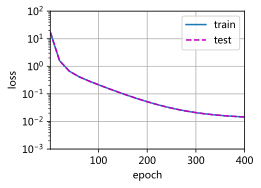

In [13]:
# 从完整多项式特征中选取所有维度
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])